# xyz coords

In [701]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [702]:
def galactic_to_cartesian(row):
    galactic_coord = SkyCoord(l=row['glon']*u.deg, b=row['glat']*u.deg,
                              distance=row['sy_dist']*u.pc,
                              unit=(u.deg, u.deg, u.pc), frame='galactic')
    cartesian_coord = galactic_coord.cartesian
    return pd.DataFrame({'X': cartesian_coord.x.value, 'Y': cartesian_coord.y.value, 'Z': cartesian_coord.z.value})

# # Apply the conversion function to each row
# df_cartesian = df.apply(galactic_to_cartesian, axis=1)

def inner_working_angle(wl, d):
    '''
    returns the inner working angle of a telescope given the wavelength of
    interest and the diameter of the telescope aperture (diffraction limit)
    '''
    return wl/d

def create_iwa_range():
    '''
    returns inner working angles for HWO given the suggested wavelength of
    interest and the diameter of the telescope aperture (6m +- .5m), assuming
    perfect coronagraph
    '''
    iwa_vis = inner_working_angle(0.6e-6, np.linspace(2, 20, 10))
    iwa_nir = inner_working_angle(1e-6, np.linspace(2, 20, 10))
    return iwa_vis, iwa_nir

def available_phase_angles(a, iwa, i, d):
    '''
    a: semi-major axis of planet orbit [pc]
    iwa: inner working angle [rad]
    i: inclination of orbit [deg]
    d: distance from sun [pc]
     '''
    cosi = np.cos(np.deg2rad(i))
    # limit = iwa * np.clip(d / a, a_min=-1, a_max=iwa**-1)
    limit = iwa * np.clip(d / a, a_min=-1, a_max=iwa**-1)
    return np.rad2deg(np.where(cosi > limit, 2 * np.deg2rad(i), 2 * np.arccos(limit)))

In [703]:
iwa_vis, iwa_nir = create_iwa_range()

In [704]:
iwa_nir*206265*1000

array([103.1325    ,  51.56625   ,  34.3775    ,  25.783125  ,
        20.6265    ,  17.18875   ,  14.73321429,  12.8915625 ,
        11.45916667,  10.31325   ])

In [707]:
exofull = pd.read_csv('/content/PSCompPars_2024.10.05_07.15.36.tab', sep='\t', comment='#')
notic_indices = exofull[exofull["tic_id"].isna()].index
exofull = exofull.drop(index=notic_indices).reset_index(drop=True)
xyz = galactic_to_cartesian(exofull)
nan_indices = xyz[xyz['X'].isna()].index
xyz = xyz.drop(index=nan_indices).reset_index(drop=True)
exofull=exofull.drop(index=nan_indices).reset_index(drop=True)

In [710]:
phase_angles = pd.DataFrame({'min': [0, 22, 50, 130], 'max':[10, 63, 110, 170]})
phase_angles.rename(index={0:'Glory', 1:'Rainbow', 2:'Rayleigh Peak', 3:'Ocean Glint'}, inplace=True)
phase_angles

,min,max
Glory,0,10
Rainbow,22,63
Rayleigh Peak,50,110
Ocean Glint,130,170


In [711]:
gcoords = exofull[['pl_name', 'tic_id', 'glon', 'glat', 'sy_dist', 'st_spectype', 'sy_vmag', 'pl_orbsmax', 'pl_orbincl', 'st_teff', 'pl_eqt', 'pl_angsep']]
gcoords.loc[pd.isna(gcoords['sy_vmag']), 'sy_vmag'] = 0
gcoords.loc[pd.isna(gcoords['st_spectype']),'st_spectype'] = 'G'
gcoords.loc[pd.isna(gcoords['pl_orbsmax']), 'pl_orbsmax'] = 0
gcoords.loc[pd.isna(gcoords['pl_orbincl']), 'pl_orbincl'] = 0
gcoords.loc[pd.isna(gcoords['st_teff']), 'st_teff'] = 0
gcoords.loc[pd.isna(gcoords['pl_eqt']), 'pl_eqt'] = 0
gcoords.loc[pd.isna(gcoords['pl_angsep']), 'pl_angsep'] = 0
gcoords['contrast'] = gcoords['pl_eqt']**4 / gcoords['st_teff']**4  # black body temperature ratio (Teff^4 ratio)
gcoords.loc[pd.isna(gcoords['contrast']), 'contrast'] = 0
gcoords.loc[:, 'pl_orbsmax'] = gcoords['pl_orbsmax'].apply(lambda x: x / 206264.806)
gcoords.loc[:, 'st_spectype'] = gcoords['st_spectype'].apply(lambda x: x[0])
gcoords['X'] = xyz['X']
gcoords['Y'] = xyz['Y']
gcoords['Z'] = xyz['Z']

<ipython-input-711-4ac59cab57b9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcoords['contrast'] = gcoords['pl_eqt']**4 / gcoords['st_teff']**4  # black body temperature ratio (Teff^4 ratio)
<ipython-input-711-4ac59cab57b9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcoords['X'] = xyz['X']
<ipython-input-711-4ac59cab57b9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [712]:
data = {'tic_id': 'Sun', 'glon': [0] , 'glat': [0], 'sy_dist': [0],
        'st_spectype': ['G'], 'sy_vmag': [-26.74], 'pl_orbsmax': 0,
        'pl_orbincl': 0, 'st_teff': 0, 'pl_eqt': 0, 'pl_angsep': 0,
        'contrast': 0, 'X': 0, 'Y': 0, 'Z': 0}  # Single-row data
df = pd.DataFrame(data)
gcoords = pd.concat([df, gcoords], ignore_index=True)

In [713]:
gcoords[['X','Y','Z']]

,X,Y,Z
0,0.000000,0.000000,0.000000
1,-1.933209,-18.828595,91.242076
2,-30.333149,89.517667,82.291193
3,-19.893004,67.535400,-27.098174
4,4.353692,11.442215,13.102995
...,...,...,...
5484,-8.392746,9.320942,-4.731448
5485,-8.392746,9.320942,-4.731448
5486,-8.392746,9.320942,-4.731448
5487,-1.375195,-28.768565,44.010845


In [714]:
gcoords[['X','Y','Z']].to_csv('xyz.csv', index=False)
gcoords[['tic_id']].to_csv('hostname.csv', index=False)
gcoords[['sy_dist', 'st_spectype', 'sy_vmag', 'st_teff']].to_csv('stars.csv', index=False)
gcoords[['pl_orbsmax', 'pl_orbincl', 'pl_eqt', 'pl_angsep', 'contrast']].to_csv('exoplanets.csv', index=False)

In [715]:
pd.isna(gcoords["tic_id"]).sum()

0

In [716]:
gcoords

,tic_id,glon,glat,sy_dist,st_spectype,sy_vmag,pl_orbsmax,pl_orbincl,st_teff,pl_eqt,pl_angsep,contrast,X,Y,Z,pl_name
0,Sun,0.00000,0.00000,0.0000,G,-26.74000,0.000000e+00,0.000,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,NaN
1,TIC 72437047,264.13775,78.28058,93.1846,G,4.72307,5.711105e-06,0.000,4874.00,0.0,12.60,0.0,-1.933209,-18.828595,91.242076,11 Com b
2,TIC 230061010,108.71900,41.04437,125.3210,K,5.01300,7.417649e-06,0.000,4213.00,0.0,12.20,0.0,-30.333149,89.517667,82.291193,11 UMi b
3,TIC 333225860,106.41269,-21.05141,75.4392,K,5.23133,3.757306e-06,0.000,4888.00,0.0,10.30,0.0,-19.893004,67.535400,-27.098174,14 And b
4,TIC 219483057,69.16849,46.94447,17.9323,K,6.61935,1.344873e-05,144.652,5338.00,0.0,155.00,0.0,4.353692,11.442215,13.102995,14 Her b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,TIC 189576919,132.00045,-20.66791,13.4054,F,4.09565,2.871164e-07,0.000,6156.77,0.0,4.42,0.0,-8.392746,9.320942,-4.731448,ups And b
5485,TIC 189576919,132.00045,-20.66791,13.4054,F,4.09565,4.013162e-06,0.000,6156.77,0.0,61.70,0.0,-8.392746,9.320942,-4.731448,ups And c
5486,TIC 189576919,132.00045,-20.66791,13.4054,F,4.09565,1.218477e-05,0.000,6156.77,0.0,187.00,0.0,-8.392746,9.320942,-4.731448,ups And d
5487,TIC 49430557,267.26323,56.79861,52.5973,G,4.30490,5.720801e-06,0.000,4836.00,0.0,22.40,0.0,-1.375195,-28.768565,44.010845,ups Leo b


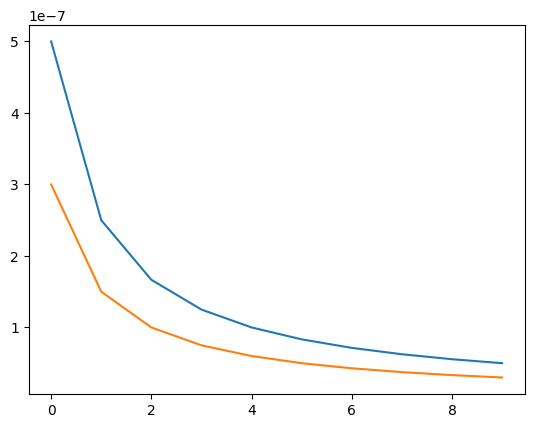

In [717]:
plt.plot(iwa_nir)
plt.plot(iwa_vis)
plt.show()

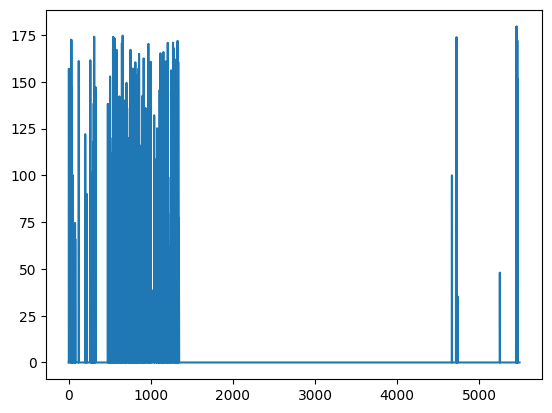

In [718]:
 plt.plot(available_phase_angles(gcoords['pl_orbsmax'], iwa_vis[1], gcoords['pl_orbincl'], gcoords['sy_dist']))

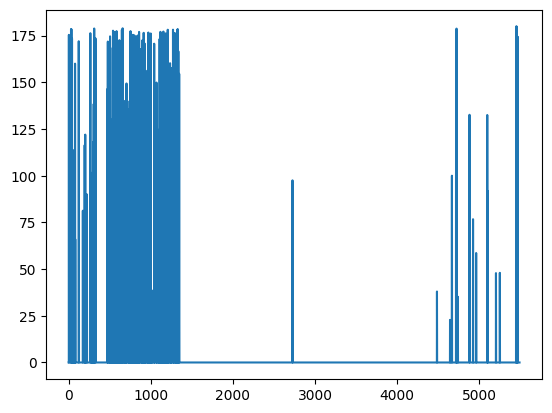

In [719]:
 plt.plot(available_phase_angles(gcoords['pl_orbsmax'], iwa_vis[9], gcoords['pl_orbincl'], gcoords['sy_dist']))

In [720]:
xyz.shape

(5488, 3)

In [721]:
vis_phase_matrix = np.zeros([10, gcoords.shape[0]])
nir_phase_matrix = np.zeros([10, gcoords.shape[0]])
for i, iwa in enumerate(iwa_vis):
    vis_phase_matrix[i, 1:] = available_phase_angles(gcoords['pl_orbsmax'], iwa, gcoords['pl_orbincl'], gcoords['sy_dist'])[1:]
for i, iwa in enumerate(iwa_nir):
    nir_phase_matrix[i, 1:] = available_phase_angles(gcoords['pl_orbsmax'], iwa, gcoords['pl_orbincl'], gcoords['sy_dist'])[1:]

In [722]:
phase_angles

,min,max
Glory,0,10
Rainbow,22,63
Rayleigh Peak,50,110
Ocean Glint,130,170


In [723]:
glorybool_vis = pd.DataFrame((90 - vis_phase_matrix/2 >= phase_angles.iloc[0]['min']) | (90 + vis_phase_matrix/2 <= phase_angles.iloc[0]['max']))
rainbowbool_vis = pd.DataFrame((90 - vis_phase_matrix/2 >= phase_angles.iloc[1]['min']) | (90 + vis_phase_matrix/2 <= phase_angles.iloc[1]['max']))
rayleighbool_vis = pd.DataFrame((90 - vis_phase_matrix/2 >= phase_angles.iloc[2]['min']) | (90 + vis_phase_matrix/2 <= phase_angles.iloc[2]['max']))
glintbool_vis = pd.DataFrame((90 - vis_phase_matrix/2 >= phase_angles.iloc[3]['min']) | (90 + vis_phase_matrix/2 <= phase_angles.iloc[3]['max']))
glorybool_nir = pd.DataFrame((90 - nir_phase_matrix/2 >= phase_angles.iloc[0]['min']) | (90 + nir_phase_matrix/2 <= phase_angles.iloc[0]['max']))
rainbowbool_nir = pd.DataFrame((90 - nir_phase_matrix/2 >= phase_angles.iloc[1]['min']) | (90 + nir_phase_matrix/2 <= phase_angles.iloc[1]['max']))
rayleighbool_nir = pd.DataFrame((90 - nir_phase_matrix/2 >= phase_angles.iloc[2]['min']) | (90 + nir_phase_matrix/2 <= phase_angles.iloc[2]['max']))
glintbool_nir = pd.DataFrame((90 - nir_phase_matrix/2 >= phase_angles.iloc[3]['min']) | (90 + nir_phase_matrix/2 <= phase_angles.iloc[3]['max']))

In [724]:
glorybool_vis.to_csv('glorybool_vis.csv', index=False)
rainbowbool_vis.to_csv('rainbowbool_vis.csv', index=False)
rayleighbool_vis.to_csv('rayleighbool_vis.csv', index=False)
glintbool_vis.to_csv('glintbool_vis.csv', index=False)
glorybool_nir.to_csv('glorybool_nir.csv', index=False)
rainbowbool_nir.to_csv('rainbowbool_nir.csv', index=False)
rayleighbool_nir.to_csv('rayleighbool_nir.csv', index=False)
glintbool_nir.to_csv('glintbool_nir.csv', index=False)

In [726]:
stars_bkns = pd.read_csv('/content/DI_STARS_EXEP_2024.10.06_09.19.08.csv', comment="#")

In [736]:
"<a href="https://exoplanetarchive.ipac.caltech.edu/overview/"

array(['Sun', 'TIC 72437047', 'TIC 230061010', ..., 'TIC 189576919',
       'TIC 49430557', 'TIC 375464367'], dtype=object)

In [748]:
# stars_bkns["hostname" ] == gcoords["hostname"]
# gcoords["hostname"].unique().isin(stars_bkns["hostname"])
# np.any(my_array[:, 0] == value)
stars = []
for star in stars_bkns["tic_id"]:
    if "exoplanetarchive" in star:
        star = star[60:]
        idx_quotes = star.find('"')
        star = star[:idx_quotes]
    if star in gcoords["tic_id"].unique():
        stars.append(star)
stars_bkns_df = pd.DataFrame(stars, columns=['tic_id'])
stars_bkns_df

,tic_id
0,TIC 136916387
1,TIC 350673608
2,TIC 362661163
3,TIC 231698181
4,TIC 434210589
5,TIC 301051051
6,TIC 261136679
7,TIC 458494003
8,TIC 179348425
9,TIC 422478973


In [750]:
stars_bkns_df.to_csv('stars_bkns.csv', index=False)

In [751]:
stars2 = pd.read_csv('/content/hostname.csv', comment="#")

In [754]:
xyz2 = pd.read_csv('/content/xyz.csv', comment="#")

In [758]:
stars2.head()

,tic_id
0,Sun
1,TIC 72437047
2,TIC 230061010
3,TIC 333225860
4,TIC 219483057


In [756]:
len(xyz2)

5489

In [759]:
bkns = []
for i in range(len(stars2)):
    if stars2["tic_id"][i] in stars_bkns_df["tic_id"].unique():
        bkns.append(1)
    else:
        bkns.append(0)

In [761]:
np.array(bkns).sum()

69

In [762]:
len(stars_bkns_df)

29

In [765]:
len(stars2['tic_id'])

5489

In [767]:
xyz2.insert(3, 'bkn', bkns, True)

In [768]:
xyz2.to_csv('xyz_bkn.csv', index=False)

In [773]:
df_stars = pd.read_csv('xyz_bkn.csv')

df_names = pd.read_csv('hostname.csv')
df = df_stars.join(df_names)

df_small = df.drop_duplicates(subset=['tic_id'])
df_names = df_small.filter(['tic_id'])

df_coords = df_small.filter(['X', 'Y', 'Z', 'bkn'])

df_coords.to_csv('xyz.txt', sep=',', index=False, header=False)
df_names.to_csv('names.txt', sep=',', index=False, header=False)